# Training Evnironment for Semantic Segmentation U-Net Model

# Load Image Data

/home/holindauer/anaconda3/envs/torch-env/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'libc10_cuda.so: cannot open shared object file: No such file or directory'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


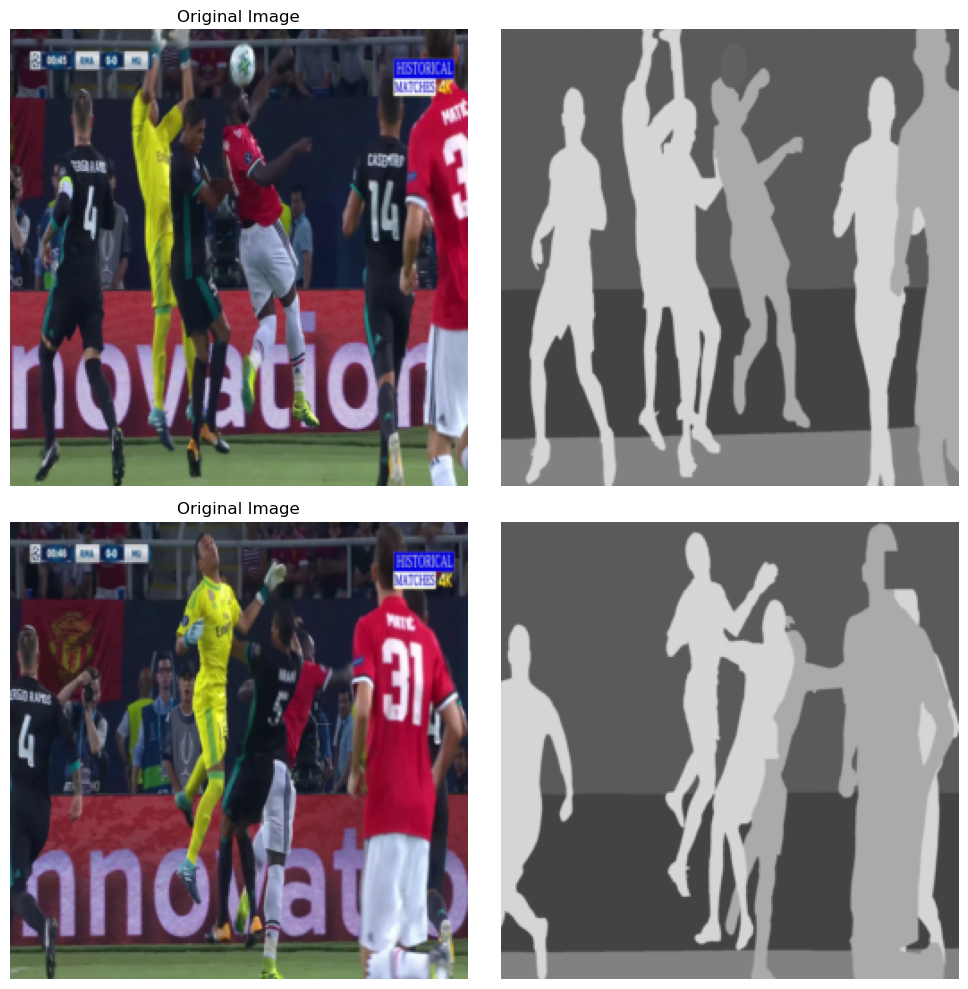

In [1]:
from dataReader import DataReader

# init data reader object
dataReader = DataReader()

# load test and train sets
trainDataset = dataReader.loadSegmentationDataset('Data/originalTrain', 'Data/segmentationTrain')
testDataset = dataReader.loadSegmentationDataset('Data/originalTest', 'Data/segmentationTest')

trainDataLoader = dataReader.wrapDataLoader(trainDataset, batchSize=10)
testDataLoader = dataReader.wrapDataLoader(testDataset, batchSize=10)

# Use the modified plotExamples method
dataReader.plot.plot_examples(testDataLoader, num_pairs=2)

# Init Model

Here I am loading in the model and setting its configurtation for training. The model is a U-Net type network with a downsampling component, followed by an upsampling component. 

The football segmentation dataset has 11 segmentation classes, but all within a single grayscale channel. 

In [2]:
from dataclasses import dataclass
from segmentationNet import SegmentationNet, SegNetConfig
import torch
import torch.nn.functional as F
from torch import nn

# set configuration
config = SegNetConfig(
    downsampling_channels=[64, 128, 256],
    upsampling_channels=[256, 128, 64],
    final_channels=[32, 16],
    num_classes=1,  # Number of segmentation classes
    channel_multiplier=2
)

# Instantiate model
model = SegmentationNet(config)

Here is the model printout

In [3]:
print(model)

SegmentationNet(
  (down_blocks): ModuleList(
    (0): Sequential(
      (0): ConvDownsamplingBlock(
        (conv): Conv2d(3, 64, kernel_size=(2, 2), stride=(1, 1), padding=same)
        (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): ConvDownsamplingBlock(
        (conv): Conv2d(64, 64, kernel_size=(2, 2), stride=(1, 1), padding=same)
        (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): Sequential(
      (0): ConvDownsamplingBlock(
        (conv): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1), padding=same)
        (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): ConvDownsamplingBlock(
        (conv): Conv2d(128, 128, kernel_size=(2, 2), stride=(1, 1), padding=same)
        (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): Sequential(
      (0): 

Here is an example forward pass using the model and dataloader.

In [4]:
# Test forward pass using dataloader

# Get a batch of data
inputs, targets = next(iter(testDataLoader))

print(f"Input Shape: {inputs.shape}")
print(f"Target Shape: {targets.shape}")

# Forward pass
outputs = model(inputs)
print(f"\nOutput Shape: {outputs.shape}")


Input Shape: torch.Size([10, 3, 256, 256])
Target Shape: torch.Size([10, 1, 256, 256])


/home/holindauer/anaconda3/envs/torch-env/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /opt/conda/conda-bld/pytorch_1702400268359/work/aten/src/ATen/native/Convolution.cpp:1008.)
  return F.conv2d(input, weight, bias, self.stride,



Output Shape: torch.Size([10, 1, 256, 256])


In [5]:
from train import Trainer, TrainConfig

# Define the trainer configuration
trainConfig = TrainConfig(
    model=model,
    trainLoader=trainDataLoader,
    testLoader=testDataLoader,
    criterion=nn.MSELoss(),
    optimizer=torch.optim.Adam(model.parameters(), lr=0.0001),
    epochs=5
)

# Instantiate the trainer
trainer = Trainer(trainConfig)

In [6]:
len(testDataLoader)

1

# Train the Model

In [7]:
model = trainer.train()

Epoch 1 Train Loss: 0.8839 Test Loss: 0.0132                                                        
Epoch 2 Train Loss: 0.3944 Test Loss: 0.0081                                                        
Epoch 3 Train Loss: 0.2793 Test Loss: 0.0057                                                        
Epoch 4 Train Loss: 0.2337 Test Loss: 0.0050                                                        
Epoch 5 Train Loss: 0.2056 Test Loss: 0.0046                                                        


# Inspect Results

In [8]:
# get batch
inputs, targets = next(iter(testDataLoader))

# run forward pass on trained model
outputs = model(inputs)
print(f"\nOutput Shape: {outputs.shape}")


Output Shape: torch.Size([10, 1, 256, 256])


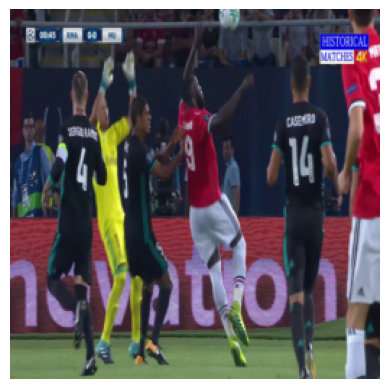

In [9]:

dataReader.plot.imshow(inputs[0])



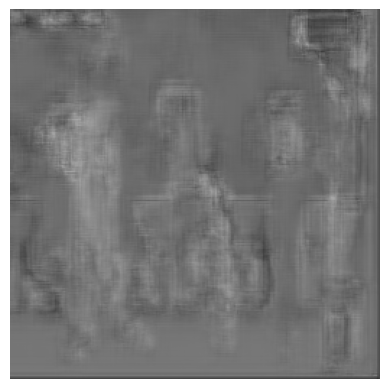

In [10]:
dataReader.plot.imshow(outputs[0])